In [27]:
import numpy as np
import pandas as pd
import matplotlib as plt
import torch 
import torch.nn as nn
import yfinance as yf
import keras 
import os
import tensorflow
import datetime 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Activation
from keras import optimizers
from keras.models import Model
from keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [28]:
def TickerIntoTensor(ticker='aapl',daysago=100,daysforward=10,split_percentage=0.9):
    df = yf.Ticker(ticker.upper())
    df = df.history(period='max')
    if df.shape[1] == 7:
        df = df.drop(columns=['Dividends','Stock Splits'])
    df = df.drop(columns=['Open','High','Low','Volume'])
    for i in range(daysago,-daysforward-1,-1):
        df['{}daysago'.format(i)] = df['Close'].shift(i)
        df = df.copy()
    df = df.drop(columns=['Close'])
    df = df.drop(index=df.tail(daysforward).index)
    df = df.drop(index=df.head(daysago).index)
    sc = MinMaxScaler(feature_range=(0,1))
    df_scaled = sc.fit_transform(df)
    X,Y = df_scaled[:,:daysago+1],df_scaled[:,-daysforward:]
    split = int(len(X)*split_percentage)
    X_train, X_test, Y_train, Y_test = X[:split], X[split:], Y[:split], Y[split:]
    X_train, X_test, Y_train, Y_test = X_train.reshape((-1,daysago+1,1)), X_test.reshape((-1,daysago+1,1)), Y_train.reshape((-1,daysforward,1)), Y_test.reshape((-1,daysforward,1))
    #X_train, X_test, Y_train, Y_test = torch.tensor(X_train).float(), torch.tensor(X_test).float(), torch.tensor(Y_train).float(), torch.tensor(Y_test).float()
    return X_train, X_test, Y_train, Y_test
TickerIntoTensor()

(array([[[3.09576887e-04],
         [2.83417060e-04],
         [2.48533543e-04],
         ...,
         [2.84889914e-04],
         [2.64843557e-04],
         [2.69428521e-04]],
 
        [[2.83417060e-04],
         [2.48533543e-04],
         [2.59433289e-04],
         ...,
         [2.72413745e-04],
         [2.70908255e-04],
         [2.73449534e-04]],
 
        [[2.48533543e-04],
         [2.59433289e-04],
         [2.72517389e-04],
         ...,
         [2.78651793e-04],
         [2.74951352e-04],
         [2.63396949e-04]],
 
        ...,
 
        [[2.67950817e-01],
         [2.66675767e-01],
         [2.70782746e-01],
         ...,
         [3.84495029e-01],
         [3.71146848e-01],
         [3.69210531e-01]],
 
        [[2.66675767e-01],
         [2.70782746e-01],
         [2.69385213e-01],
         ...,
         [3.81755569e-01],
         [3.71238280e-01],
         [3.62446936e-01]],
 
        [[2.70782746e-01],
         [2.69385213e-01],
         [2.68073416e-01],
         

In [35]:
ticker='aapl'
daysago=100
daysforward=1
split_percentage=0.9
df = yf.Ticker(ticker.upper())
df = df.history(period='max')
if df.shape[1] == 7:
    df = df.drop(columns=['Dividends','Stock Splits'])
df = df.drop(columns=['Open','High','Low','Volume'])
for i in range(daysago,-daysforward-1,-1):
    df['{}daysago'.format(i)] = df['Close'].shift(i)
    df = df.copy()
df = df.drop(columns=['Close'])
df = df.drop(index=df.tail(daysforward).index)
df = df.drop(index=df.head(daysago).index)
print(df.shape[1] == daysago+1+daysforward)
sc = MinMaxScaler(feature_range=(0,1))
df_scaled = sc.fit_transform(df)
X,Y = df_scaled[:,:daysago+1],df_scaled[:,-daysforward:]
print(Y.shape)
split = int(len(X)*split_percentage)
X_train, X_test, Y_train, Y_test = X[:split], X[split:], Y[:split], Y[split:]
X_train, X_test, Y_train, Y_test = X_train.reshape((-1,daysago+1,1)), X_test.reshape((-1,daysago+1,1)), Y_train.reshape((-1,daysforward,1)), Y_test.reshape((-1,daysforward,1))

print(Y_train.shape)

True
(10876, 1)
(9788, 1, 1)


In [36]:
model1 = Sequential()
model1.add(InputLayer((101, 1)))
model1.add(LSTM(500))
model1.add(Dense(150, 'sigmoid'))
model1.add(Dense(1, 'linear'))

cp1 = ModelCheckpoint('model/.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])
model1.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, callbacks=[cp1])

Epoch 1/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 76s 240ms/step - loss: 1.3169 - root_mean_squared_error: 1.0099 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0384
Epoch 2/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 87s 283ms/step - loss: 2.8641e-04 - root_mean_squared_error: 0.0152 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0466
Epoch 3/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 92s 301ms/step - loss: 2.6077e-04 - root_mean_squared_error: 0.0158 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0965
Epoch 4/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 87s 285ms/step - loss: 1.4136e-04 - root_mean_squared_error: 0.0115 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0345
Epoch 5/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 99s 325ms/step - loss: 3.0205e-04 - root_mean_squared_error: 0.0169 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0750
Epoch 6/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 96s 315ms/step - loss: 2.1905e-04 - root_mean_squared_error: 0.0146 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0625
Epoch 7/10
306

In [37]:
from tensorflow.keras.models import load_model
model1 = load_model('model/.keras')
y_pred = model1.predict(TickerIntoTensor('goog')[1])
Y_test = TickerIntoTensor('goog')[3].reshape(-1,10)
avg_error = (np.sum(np.sqrt((Y_test - y_pred)**2)))/len(Y_test)*100
print(avg_error)
avg_error = (np.sum(y_pred - Y_test))/len(Y_test)*100
print(avg_error)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step
32.848945313592644
-18.224771158617962


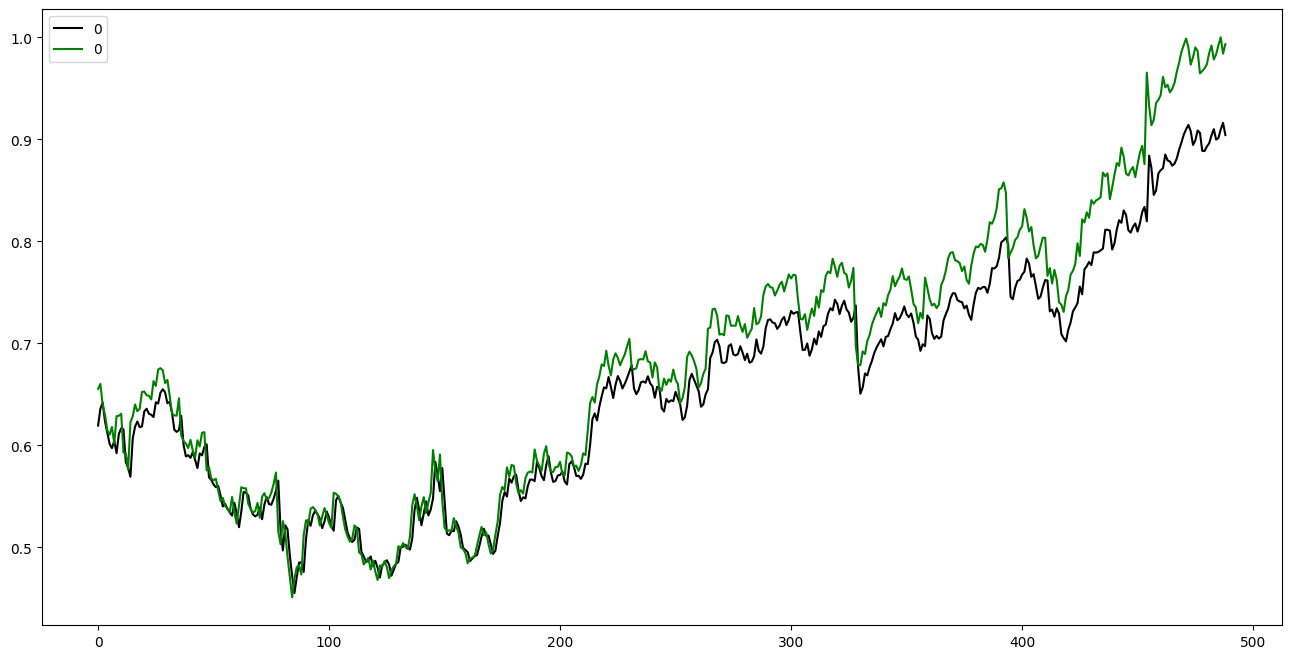

In [38]:
y_pred,Y_test = pd.DataFrame(y_pred),pd.DataFrame(Y_test)
for i in range(0,y_pred.shape[1]): 
    oneday= pd.concat([y_pred[i],Y_test[i]],axis=1)
    oneday.plot(figsize=(16,8),color = ('black','green'))

In [33]:
model1.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 500)            │     1,004,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 150)            │        75,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,237,905 (12.35 MB)

 Trainable params: 1,079,301 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,158,604 (8.23 MB)